# Generate dogs!
Uses GAN, customized variant of: <br>
Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
(Alec Radford, Luke Metz, Soumith Chintala)

In [1]:
#Other variants to try:
#-add label info to encoder input 
#-try variational GAN

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import PIL
from keras import layers
from keras import Sequential
from keras.layers import Conv2DTranspose, Conv2D, BatchNormalization, ReLU, LeakyReLU, Dropout, Dense, Activation, Input, Reshape, Flatten
import keras
import time
from IPython import display

In [2]:
output_activation = 'sigmoid'
load_checkpoint = False
data_dir='/home/evan/Datasets/tensorflow'
buffer_size = 10000
batch_size = 32
num_epochs = 5
image_size = (64,64)
channels = 3
latent_size = 120 #i.e. size of generator input
filters_gen = 64 
filters_dis = 64
lr = 0.0002
beta1 = 0.5

if output_activation = 'sigmoid':
    def normalize(x):
        return x / 255. #0 to 1 
    def denormalize(x):
        return x * 255.
if output_activation = 'tanh':
    def normalize(x):
        return (x - 127.5) / 127.5  #-1 to 1 
    def denormalize(x):
        return (x * 127.5) + 127.5 

try:
    train_dataset = tfds.load('stanford_dogs', as_supervised=False, split='train', data_dir=data_dir, download=False)
except e:
    print(e)
    train_dataset = tfds.load('stanford_dogs', as_supervised=False, split='train', data_dir=data_dir, download=True)

train_dataset = train_dataset.map(lambda x : x['image'])
# print(next(train.take(1).as_numpy_iterator()))
train_dataset = train_dataset.map(lambda x : tf.image.resize(x, (64,64)))
train_dataset = train_dataset.map(lambda x : tf.cast(x, tf.float32))
train_dataset = train_dataset.map(lambda x : normalize(x))  # Normalize the images
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


2021-10-26 14:24:45.530285: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 14:24:45.537281: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 14:24:45.537767: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-26 14:24:45.539191: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2021-10-26 14:24:48.790416: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


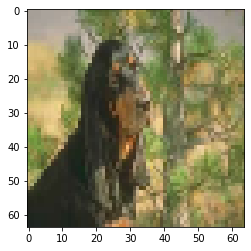

In [4]:
plt.imshow((next(train_dataset.as_numpy_iterator())[0]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 768)               92928     
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 3)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 512)       24576     
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 512)       2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       2097152   
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1

2021-10-26 14:27:44.292034: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100


(1, 64, 64, 3)
6152.2744


2021-10-26 14:27:44.909912: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


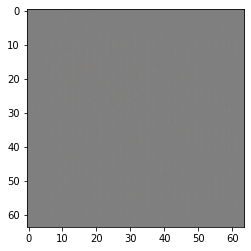

In [5]:
def make_generator_model():
    model = keras.Sequential([
            # input is Z, going into a convolution
            Input((latent_size)),
            Dense(np.prod((16,16)+(3,))),
            Reshape((16,16)+(3,)),
            Conv2DTranspose(filters = filters_gen * 8, kernel_size=4, strides=1, padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(filters_gen * 4, 4, 2, padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(filters_gen * 2, 4, 1,padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(filters_gen, 4, 2, padding='same',use_bias=False),
            BatchNormalization(),
            ReLU(),
            Conv2DTranspose(channels, 4, 1,padding='same',use_bias=False),
            Activation(output_activation)
    ])
    return model

generator = make_generator_model()
generator.summary()
noise = tf.random.normal([1, latent_size])
generated_image = generator(noise, training=False).numpy()
print(generated_image.shape)
print(generated_image.sum())
plt.imshow(generated_image[0, :, :, :])

In [6]:
def make_discriminator_model():
    model = Sequential([
        Conv2D(filters_dis,kernel_size=4, strides=2, padding='same',use_bias=False, input_shape=(64,64,3)),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(filters_dis * 2, kernel_size=4, strides=2, padding='same',use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(filters_dis * 4,kernel_size=4, strides=2, padding='same',use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),
        Conv2D(filters_dis * 8,kernel_size=4, strides=2, padding='same',use_bias=False),
        BatchNormalization(),
        LeakyReLU(0.2),
        Flatten(),
        Dense(1),
        Activation(output_activation)
    ])
    return model

discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print (decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3072      
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131072    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)        

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [8]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [9]:
generator_optimizer = tf.keras.optimizers.Adam(lr, beta1)
discriminator_optimizer = tf.keras.optimizers.Adam(lr, beta1)

In [10]:
checkpoint_dir = './training_checkpoints' + datetime.now().strftime("%H:%M:%S")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [11]:
EPOCHS = 200
noise_dim = 120
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [12]:
# Notice the use of `tf.fuchannelstion`
# This annotation causes the fuchannelstion to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [13]:
if load_checkpoint:
    ckpt = tf.train.Checkpoint(
        generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator
    )
    manager = tf.train.CheckpointManager(ckpt, './training_checkpoints/', max_to_keep=3)
    ckpt.restore(manager.latest_checkpoint)

In [14]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inferechannelse mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :])
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

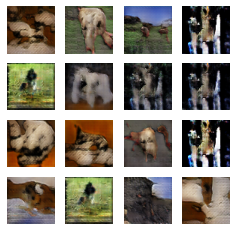

In [16]:
train(train_dataset, EPOCHS)
